In [1]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)
par_get_daily_pred
par_get_all_signal
get_signal_stat

<function helper.get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str='2018', reverse=1, tranct=0.00011, max_spread=0.61, tranct_ratio=True, min_pnl=2, min_num=20, atr_filter=0, HEAD_PATH='d:/intern', SIGNAL_PATH='d:/intern')>

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [3]:
product_list = ["rb", "hc", "i", "j", "jm"]

In [4]:
period = 4096

In [5]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 915

915

In [6]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [7]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
n_signal = len(signal_list)

In [8]:
train_sample = all_dates<"2018"
test_sample = all_dates>"2018"
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [9]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".002"

- at first we try using lasso for rb, hc, j, jm together 

In [10]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-3]
signal_names
col_names = ori_mat.columns

In [11]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = train_mat[signal_names]
#train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=signal_names)
train_mat.shape

(5266, 45)

In [12]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=col_names)
print(product_list[0], train_mat.shape)
for product in ["hc","j","jm"]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)
# rb (5266, 48)
# hc (3894, 48)
# j (3118, 48)
# jm (2999, 48)


rb (5266, 48)
hc (3894, 48)
j (3118, 48)
jm (2999, 48)


In [13]:
train_std_mat = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [14]:
x_train = train_mat.iloc[:, :n_signal].values
y_train = train_mat.loc[:, y_signal].values
scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
fit_coef = model.coef_/x_std
print(fit_coef)
# [-0.         -0.          0.01571216 -0.00036018  0.          0.0112997
#  -0.          0.         -0.         -0.         -0.          0.
#  -0.01278658 -0.         -0.          0.          0.         -0.
#  -0.00746176 -0.00949664  0.         -0.         -0.01548164 -0.
#   0.          0.         -0.         -0.          0.          0.00115205
#  -0.02323864 -0.          0.          0.          0.         -0.
#  -0.00137254  0.          0.         -0.00331034  0.          0.00530771
#   0.          0.          0.        ]


[-0.         -0.          0.01571216 -0.00036018  0.          0.0112997
 -0.          0.         -0.         -0.         -0.          0.
 -0.01278658 -0.         -0.          0.          0.         -0.
 -0.00746176 -0.00949664  0.         -0.         -0.01548164 -0.
  0.          0.         -0.         -0.          0.          0.00115205
 -0.02323864 -0.          0.          0.          0.         -0.
 -0.00137254  0.          0.         -0.00331034  0.          0.00530771
  0.          0.          0.        ]


In [34]:
coef_list=dict([])
for product in ["rb","hc","j","jm"]:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][signal_names]
    coef_list[product] = coef
    print(product)
    print(coef)

rb
trade.imb.4096                           -0.000000
total.trade.imb.4096                     -0.000000
nr.4096                                   0.002800
dbook.4096                               -0.000037
range.pos.4096                            0.000000
price.osci.4096                           0.000112
ma.dif.10.4096                           -0.000000
kdj.k.4096                                0.000000
kdj.j.4096                               -0.000000
trade.imb.range.4096                     -0.000000
total.trade.imb.range.4096               -0.000000
nr.range.4096                             0.000000
dbook.range.4096                         -0.000048
range.pos.range.4096                     -0.000000
price.osci.range.4096                    -0.000000
ma.dif.10.range.4096                      0.000000
kdj.k.range.4096                          0.000000
kdj.j.range.4096                         -0.000000
trade.imb.std.4096                       -0.000171
total.trade.imb.std.4096    

In [35]:
strat = "overall.lasso.002."+str(period)
for product in product_list:
    os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
    
for product in product_list:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [37]:
%%time
for product in ["rb","hc","j","jm"]:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern")

# rb
# hc
# j
# jm
# Wall time: 21min 50s

rb
hc
j
jm
Wall time: 21min 50s


In [41]:
%%time
for product in ["rb","hc","j","jm"]:
    par_get_all_signal(strat, all_dates, product, 4096, HEAD_PATH="e:/intern")

Wall time: 1min 7s


In [47]:
%%time
for product in ["rb","hc","j","jm"]:
    spread = product_info[product]["spread"]
    evaluate_signal("overall.lasso.002", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, SIGNAL_PATH="e:/intern",
                    period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 9min 45s


reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 4min 57s


In [48]:
# we save the result of i lasso.002.4096 to another file overall.lasso.002.4096
signal_stat = load(HEAD_PATH+"/signal result atr/"+"i"+"."+"lasso.002.4096"+".trend.pkl")
save(signal_stat, HEAD_PATH+"/signal result atr/"+"i"+"."+"overall.lasso.002.4096"+".trend.pkl")

In [50]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"overall.lasso.002.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# rb train sharpe  1.1530164630600237 test sharpe  1.5067433544527533
# hc train sharpe  1.4029104175429374 test sharpe  0.44701175768572476
# i train sharpe  0.8872894801115896 test sharpe  1.2391069972827167
# j train sharpe  1.934567536328342 test sharpe  1.4775609096621738
# jm train sharpe  1.0721787230723798 test sharpe  0.7304099893727429


rb train sharpe  1.1530164630600237 test sharpe  1.5067433544527533
hc train sharpe  1.4029104175429374 test sharpe  0.44701175768572476
i train sharpe  0.8872894801115896 test sharpe  1.2391069972827167
j train sharpe  1.934567536328342 test sharpe  1.4775609096621738
jm train sharpe  1.0721787230723798 test sharpe  0.7304099893727429


rb train sharpe  1.1573394555359664 test sharpe  1.5067433544527522
hc train sharpe  1.4029104175429374 test sharpe  0.44701175768572476
i train sharpe  1.0578039802590233 test sharpe  0.7404904012321055
j train sharpe  1.882628152705039 test sharpe  1.4707256045526333
jm train sharpe  1.169831922470172 test sharpe  0.7730535623940026
train sharpe:  2.0557422122189277 test sharpe:  1.9364802070196268


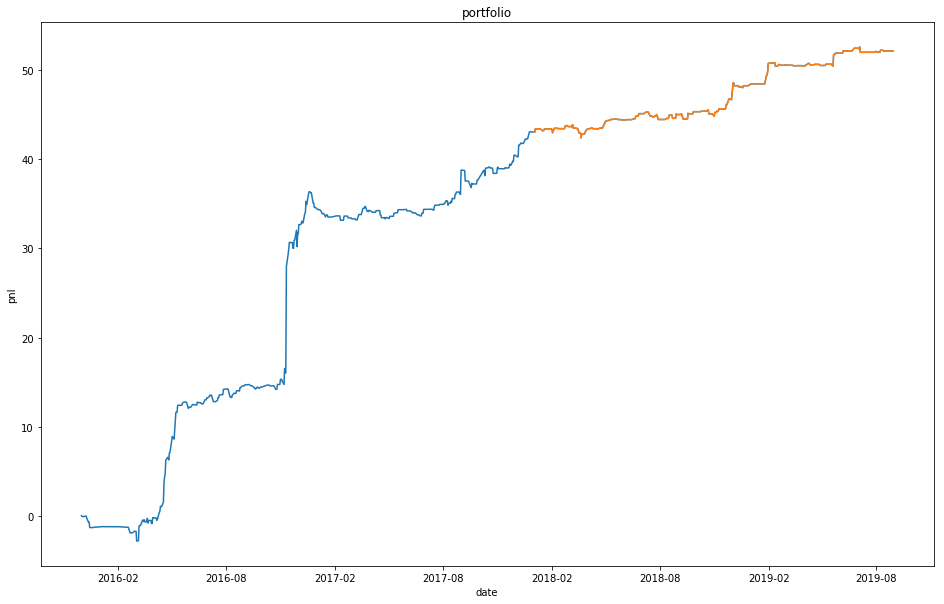

In [51]:
i = 0
strat = "overall.lasso.002.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    
# rb train sharpe  1.1573394555359664 test sharpe  1.5067433544527522
# hc train sharpe  1.4029104175429374 test sharpe  0.44701175768572476
# i train sharpe  1.0578039802590233 test sharpe  0.7404904012321055
# j train sharpe  1.882628152705039 test sharpe  1.4707256045526333
# jm train sharpe  1.169831922470172 test sharpe  0.7730535623940026
# train sharpe:  2.0557422122189277 test sharpe:  1.9364802070196268




- we can see that the result is much better than before
- so we can use this method for rolling models
- However, using the previous method may be too slow
- we calcualte the predictions values of each product using 26 mintues, and other time add up together would be 30 mintues
- if we are rolling on a monthly basis
- from 201801 to 201908 there are 20 months
- so it may use 10 hours for the rolling

- rolling model

- at first we need to know how many ticks every day

In [66]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_mat
    all_mat[product] = pd.concat((train_mat, test_mat))

- at first we can try a not so intensive method
- we can get the starting day for train

In [57]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV

- at first we can try a not so intensive method
- we can get the starting day for train

In [44]:
from sklearn.preprocessing import StandardScaler

- now we generate prediction values for next 22 days

- now we can combien all these and get a function for rolling
- we can also use calendar month rather than 22 days

In [41]:
month = np.array([file[:6] for file in all_dates])

In [42]:
month_len = np.unique(month, return_counts=True)
month_len
# (array(['201512', '201601', '201602', '201603', '201604', '201605',
#         '201606', '201607', '201608', '201609', '201610', '201611',
#         '201612', '201701', '201702', '201703', '201704', '201705',
#         '201706', '201707', '201708', '201709', '201710', '201711',
#         '201712', '201801', '201802', '201803', '201804', '201805',
#         '201806', '201807', '201808', '201809', '201810', '201811',
#         '201812', '201901', '201902', '201903', '201904', '201905',
#         '201906', '201907', '201908'], dtype='<U6'),
#  array([22, 20, 16, 23, 20, 21, 20, 21, 23, 20, 16, 22, 22, 18, 18, 23, 18,
#         20, 22, 21, 23, 21, 17, 22, 21, 22, 15, 22, 18, 22, 20, 22, 23, 19,
#         18, 22, 20, 22, 15, 21, 21, 20, 19, 23, 21], dtype=int64))

(array(['201512', '201601', '201602', '201603', '201604', '201605',
        '201606', '201607', '201608', '201609', '201610', '201611',
        '201612', '201701', '201702', '201703', '201704', '201705',
        '201706', '201707', '201708', '201709', '201710', '201711',
        '201712', '201801', '201802', '201803', '201804', '201805',
        '201806', '201807', '201808', '201809', '201810', '201811',
        '201812', '201901', '201902', '201903', '201904', '201905',
        '201906', '201907', '201908'], dtype='<U6'),
 array([22, 20, 16, 23, 20, 21, 20, 21, 23, 20, 16, 22, 22, 18, 18, 23, 18,
        20, 22, 21, 23, 21, 17, 22, 21, 22, 15, 22, 18, 22, 20, 22, 23, 19,
        18, 22, 20, 22, 15, 21, 21, 20, 19, 23, 21], dtype=int64))

In [210]:
def get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat, 
                          single_product, combine_product, period=4096, SAVE_PATH="e:/intern"):
    product_list = np.append(single_product, combine_product)
    cum_daily_ticks = dict([])
    train_tick_start = dict([])
    train_tick_end = dict([])   
    test_tick_start = dict([])
    test_tick_end = dict([])   
    for product in product_list:
        cum_daily_ticks[product] = daily_ticks[product].cumsum()
        if train_start==0:
            train_tick_start[product] = 0
        else:
            train_tick_start[product] = int(cum_daily_ticks[product][train_start-1]+1)
        train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1)
        test_tick_start[product] = int(train_tick_end[product]+2)
        test_tick_end[product] = int(cum_daily_ticks[product][train_end+1])
        
    coef_list = dict([])
    for product in single_product:
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        n_train = x_train.shape[0]
        scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
        scaler.fit(x_train)
        x_std = np.sqrt(scaler.var_)
        x_train_normal = scaler.transform(x_train)
        model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
        coef = model.coef_ / x_std
        coef_list[product] = coef
    train_std_mat = dict([])
    train_std_mat
    n_samples = x_train.shape[0]
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    for product in combine_product:
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        scaler.fit(x_train)
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_train = np.append(y_train, cur_y_train)
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(train_mat, y_train)
    fit_coef = model.coef_
    for product in combine_product:
        coef_list[product] = fit_coef/train_std_mat[product]
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save(coef_list, SAVE_PATH+"/model/"+strat+".pkl")
    


In [44]:
test_range = np.where((month_len[0] > "2018" ) & (month_len[0]<"201909"))[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < "2018")-1
cum_month_len = np.cumsum(month_len[1])

['201801' '201802' '201803' '201804' '201805' '201806' '201807' '201808'
 '201809' '201810' '201811' '201812' '201901' '201902' '201903' '201904'
 '201905' '201906' '201907' '201908']


In [212]:
%%time
strat = "overall.lasso.002.4096"
y_signal = "ret.4096.002"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat+"."+month_len[0][i_test], 
                          ["i"], ["rb","hc","j","jm"], period=4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1
    
# 25 201801
# 26 201802
# 27 201803
# 28 201804
# 29 201805
# 30 201806
# 31 201807
# 32 201808
# 33 201809
# 34 201810
# 35 201811
# 36 201812
# 37 201901
# 38 201902
# 39 201903
# 40 201904
# 41 201905
# 42 201906
# 43 201907
# 44 201908
# Wall time: 1min 59s


25 201801
26 201802
27 201803
28 201804
29 201805
30 201806
31 201807
32 201808
33 201809
34 201810
35 201811
36 201812
37 201901
38 201902
39 201903
40 201904
41 201905
42 201906
43 201907
44 201908
Wall time: 1min 59s


- Then we can generate prediction values of each model

In [220]:
%%time
start_month = 0
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    strat_name = strat+"."+month_len[0][i_test]
    coef_list = load(SAVE_PATH+"/model/"+strat_name+".pkl")
    for product in product_list:
        coef = coef_list[product]
        os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
        parLapply(CORE_NUM, all_dates[train_start:(train_end+forward_len)+1], par_get_daily_pred, 
                  product=product, coef=coef, strat=strat_name, HEAD_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 25 201801
# 26 201802
# 27 201803
# 28 201804
# 29 201805
# 30 201806
# 31 201807
# 32 201808
# 33 201809
# 34 201810
# 35 201811
# 36 201812
# 37 201901
# 38 201902
# 39 201903
# 40 201904
# 41 201905
# 42 201906
# 43 201907
# 44 201908
# Wall time: 4h 54min 51s

25 201801
26 201802
27 201803
28 201804
29 201805
30 201806
31 201807
32 201808
33 201809
34 201810
35 201811
36 201812
37 201901
38 201902
39 201903
40 201904
41 201905
42 201906
43 201907
44 201908
Wall time: 4h 54min 51s


In [224]:
%%time
strat = "overall.lasso.002.4096"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(month_len[0][i_test], all_dates[train_start], all_dates[train_end])
    for product in product_list:
        par_get_all_signal(strat+"."+month_len[0][i_test], all_dates[train_start:(train_end+1)], product, 4096, HEAD_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 201801 20151202.pkl 20180102.pkl
# 201802 20160104.pkl 20180201.pkl
# 201803 20160201.pkl 20180301.pkl
# 201804 20160301.pkl 20180402.pkl
# 201805 20160401.pkl 20180502.pkl
# 201806 20160503.pkl 20180601.pkl
# 201807 20160601.pkl 20180702.pkl
# 201808 20160701.pkl 20180801.pkl
# 201809 20160801.pkl 20180903.pkl
# 201810 20160901.pkl 20181008.pkl
# 201811 20161010.pkl 20181101.pkl
# 201812 20161101.pkl 20181203.pkl
# 201901 20161201.pkl 20190102.pkl
# 201902 20170103.pkl 20190201.pkl
# 201903 20170203.pkl 20190301.pkl
# 201904 20170301.pkl 20190401.pkl
# 201905 20170405.pkl 20190506.pkl
# 201906 20170502.pkl 20190603.pkl
# 201907 20170601.pkl 20190701.pkl
# 201908 20170703.pkl 20190801.pkl
# Wall time: 16min 6s

## I made a mistake here, all_dates[train_start:(train_end+1)] would end at train_end, so I should not print the train_end+1 point 

201801 20151202.pkl 20180102.pkl
201802 20160104.pkl 20180201.pkl
201803 20160201.pkl 20180301.pkl
201804 20160301.pkl 20180402.pkl
201805 20160401.pkl 20180502.pkl
201806 20160503.pkl 20180601.pkl
201807 20160601.pkl 20180702.pkl
201808 20160701.pkl 20180801.pkl
201809 20160801.pkl 20180903.pkl
201810 20160901.pkl 20181008.pkl
201811 20161010.pkl 20181101.pkl
201812 20161101.pkl 20181203.pkl
201901 20161201.pkl 20190102.pkl
201902 20170103.pkl 20190201.pkl
201903 20170203.pkl 20190301.pkl
201904 20170301.pkl 20190401.pkl
201905 20170405.pkl 20190506.pkl
201906 20170502.pkl 20190603.pkl
201907 20170601.pkl 20190701.pkl
201908 20170703.pkl 20190801.pkl
Wall time: 16min 6s


In [270]:
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal result atr", HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] < "2018")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                             product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                             max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                             max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        test_stat = get_hft_summary(test_result, thre_mat, forward_len)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [271]:
%%time
strat = "overall.lasso.002.4096"
for product in product_list:
    get_lasso_roll_result(product, strat, test_range, month_len, atr_filter=20)

# rb 25 overall.lasso.002.4096.201801
# rb 26 overall.lasso.002.4096.201802
# rb 27 overall.lasso.002.4096.201803
# rb 28 overall.lasso.002.4096.201804
# rb 29 overall.lasso.002.4096.201805
# rb 30 overall.lasso.002.4096.201806
# rb 31 overall.lasso.002.4096.201807
# rb 32 overall.lasso.002.4096.201808
# rb 33 overall.lasso.002.4096.201809
# rb 34 overall.lasso.002.4096.201810
# rb 35 overall.lasso.002.4096.201811
# rb 36 overall.lasso.002.4096.201812
# rb 37 overall.lasso.002.4096.201901
# rb 38 overall.lasso.002.4096.201902
# rb 39 overall.lasso.002.4096.201903
# rb 40 overall.lasso.002.4096.201904
# rb 41 overall.lasso.002.4096.201905
# rb 42 overall.lasso.002.4096.201906
# rb 43 overall.lasso.002.4096.201907
# rb 44 overall.lasso.002.4096.201908
# hc 25 overall.lasso.002.4096.201801
# hc 26 overall.lasso.002.4096.201802
# hc 27 overall.lasso.002.4096.201803
# hc 28 overall.lasso.002.4096.201804
# hc 29 overall.lasso.002.4096.201805
# hc 30 overall.lasso.002.4096.201806
# hc 31 overall.lasso.002.4096.201807
# hc 32 overall.lasso.002.4096.201808
# hc 33 overall.lasso.002.4096.201809
# hc 34 overall.lasso.002.4096.201810
# hc 35 overall.lasso.002.4096.201811
# hc 36 overall.lasso.002.4096.201812
# hc 37 overall.lasso.002.4096.201901
# hc 38 overall.lasso.002.4096.201902
# hc 39 overall.lasso.002.4096.201903
# hc 40 overall.lasso.002.4096.201904
# hc 41 overall.lasso.002.4096.201905
# hc 42 overall.lasso.002.4096.201906
# hc 43 overall.lasso.002.4096.201907
# hc 44 overall.lasso.002.4096.201908
# i 25 overall.lasso.002.4096.201801
# i 26 overall.lasso.002.4096.201802
# i 27 overall.lasso.002.4096.201803
# i 28 overall.lasso.002.4096.201804
# i 29 overall.lasso.002.4096.201805
# i 30 overall.lasso.002.4096.201806
# i 31 overall.lasso.002.4096.201807
# i 32 overall.lasso.002.4096.201808
# i 33 overall.lasso.002.4096.201809
# i 34 overall.lasso.002.4096.201810
# i 35 overall.lasso.002.4096.201811
# i 36 overall.lasso.002.4096.201812
# i 37 overall.lasso.002.4096.201901
# i 38 overall.lasso.002.4096.201902
# i 39 overall.lasso.002.4096.201903
# i 40 overall.lasso.002.4096.201904
# i 41 overall.lasso.002.4096.201905
# i 42 overall.lasso.002.4096.201906
# i 43 overall.lasso.002.4096.201907
# i 44 overall.lasso.002.4096.201908
# j 25 overall.lasso.002.4096.201801
# j 26 overall.lasso.002.4096.201802
# j 27 overall.lasso.002.4096.201803
# j 28 overall.lasso.002.4096.201804
# j 29 overall.lasso.002.4096.201805
# j 30 overall.lasso.002.4096.201806
# j 31 overall.lasso.002.4096.201807
# j 32 overall.lasso.002.4096.201808
# j 33 overall.lasso.002.4096.201809
# j 34 overall.lasso.002.4096.201810
# j 35 overall.lasso.002.4096.201811
# j 36 overall.lasso.002.4096.201812
# j 37 overall.lasso.002.4096.201901
# j 38 overall.lasso.002.4096.201902
# j 39 overall.lasso.002.4096.201903
# j 40 overall.lasso.002.4096.201904
# j 41 overall.lasso.002.4096.201905
# j 42 overall.lasso.002.4096.201906
# j 43 overall.lasso.002.4096.201907
# j 44 overall.lasso.002.4096.201908
# jm 25 overall.lasso.002.4096.201801
# jm 26 overall.lasso.002.4096.201802
# jm 27 overall.lasso.002.4096.201803
# jm 28 overall.lasso.002.4096.201804
# jm 29 overall.lasso.002.4096.201805
# jm 30 overall.lasso.002.4096.201806
# jm 31 overall.lasso.002.4096.201807
# jm 32 overall.lasso.002.4096.201808
# jm 33 overall.lasso.002.4096.201809
# jm 34 overall.lasso.002.4096.201810
# jm 35 overall.lasso.002.4096.201811
# jm 36 overall.lasso.002.4096.201812
# jm 37 overall.lasso.002.4096.201901
# jm 38 overall.lasso.002.4096.201902
# jm 39 overall.lasso.002.4096.201903
# jm 40 overall.lasso.002.4096.201904
# jm 41 overall.lasso.002.4096.201905
# jm 42 overall.lasso.002.4096.201906
# jm 43 overall.lasso.002.4096.201907
# jm 44 overall.lasso.002.4096.201908
# Wall time: 1h 19min 44s


rb 25 overall.lasso.002.4096.201801
rb 26 overall.lasso.002.4096.201802
rb 27 overall.lasso.002.4096.201803
rb 28 overall.lasso.002.4096.201804
rb 29 overall.lasso.002.4096.201805
rb 30 overall.lasso.002.4096.201806
rb 31 overall.lasso.002.4096.201807
rb 32 overall.lasso.002.4096.201808
rb 33 overall.lasso.002.4096.201809
rb 34 overall.lasso.002.4096.201810
rb 35 overall.lasso.002.4096.201811
rb 36 overall.lasso.002.4096.201812
rb 37 overall.lasso.002.4096.201901
rb 38 overall.lasso.002.4096.201902
rb 39 overall.lasso.002.4096.201903
rb 40 overall.lasso.002.4096.201904
rb 41 overall.lasso.002.4096.201905
rb 42 overall.lasso.002.4096.201906
rb 43 overall.lasso.002.4096.201907
rb 44 overall.lasso.002.4096.201908
hc 25 overall.lasso.002.4096.201801
hc 26 overall.lasso.002.4096.201802
hc 27 overall.lasso.002.4096.201803
hc 28 overall.lasso.002.4096.201804
hc 29 overall.lasso.002.4096.201805
hc 30 overall.lasso.002.4096.201806
hc 31 overall.lasso.002.4096.201807
hc 32 overall.lasso.002.4096

sharpe  2.2515152456197316


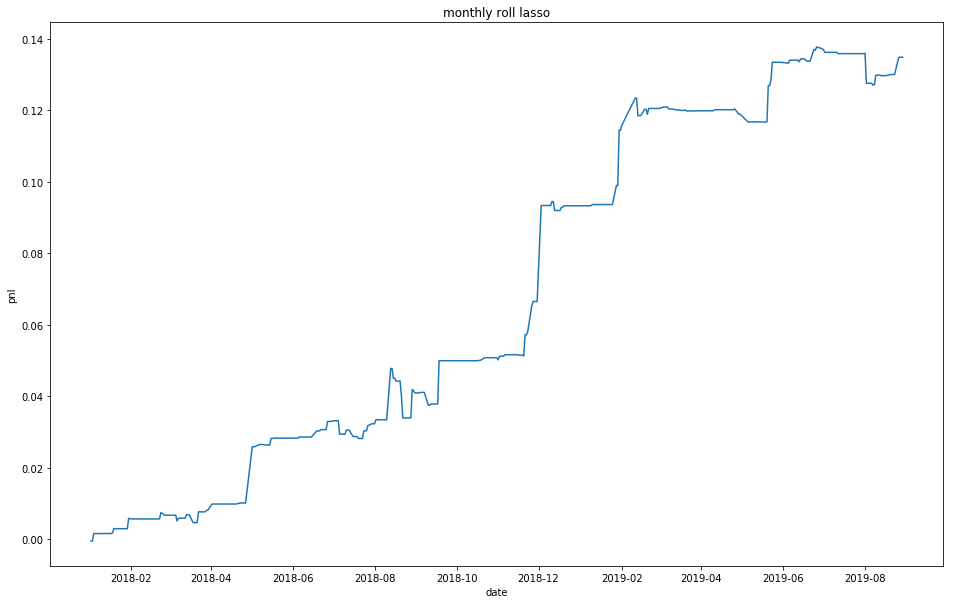

In [46]:
n_product = len(product_list)
save_path = "signal result atr"
strat = "overall.lasso.002.4096"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
all_pnl = np.array([])
capital = 1e3
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    train_mat = np.zeros((train_end-train_start+1, n_product))
    test_mat = np.zeros((forward_len, n_product))
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
        train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        train_mat[:,i_product] = train_pnl/capital
        test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/capital
        test_pnl[np.isnan(test_pnl)]=0
        test_mat[:,i_product] = test_pnl
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    #parity_weight = risk_parity(train_mat)
    #diagonal_weight = risk_parity(train_mat, only_diag=True)
    #avg_test_pnl = test_mat.mean(axis=1)
    avg_test_pnl = np.dot(test_mat, sharpe_weight)
    #avg_test_pnl = np.dot(test_mat, parity_weight)
    #avg_test_pnl = np.dot(test_mat, diagonal_weight)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    start_month = start_month+1
    end_month = end_month+1
plt.figure(1, figsize=(16, 10))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], all_pnl.cumsum());
print("sharpe ", sharpe(all_pnl))

## sharpe  2.1251684630027663 ## avg
## sharpe  2.2515152456197316 ## sharpe
## sharpe  1.3967417699240174 ## risk parity

- we can repeat this process for other models but it may be too time-consuming
- you can do this as homework